<a href="https://colab.research.google.com/github/raquelaoki/TryCatch2019/blob/master/DataScienceWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Presentation Link: https://docs.google.com/presentation/d/1stycVGd0RHCH9p0wX_cP_OkKFzy8PaU0SKCQWNVRYtc/edit?usp=sharing 
_________
# Try/CATCH 2019

### Raquel Aoki and Sashini Herath

This Exercises is based on Professor Greg Baker class notes. 

## Pup Inflation: Analysing Tweets

This question is heavily inspired by David H. Montgomery's Pup Inflation post. His analysis is an excellent data science task, and we will ask the same question here: has there been grade inflation on the @dog_rates Twitter, which rates the cuteness of users' dog pictures?

We have the file dog_rates_tweets.csv with some of the twittes from this profile. To look for score inflation, we'll first have to make sense of the data. The necessary steps to do this:

1) Load the data from the CSV into a DataFrame. (Assume a dog_rates_tweets.csv file is in the same folder as the notebook file.)

2) Find tweets that contain an “/10” rating (because not all do). Extract the numeric rating. Exclude tweets that don't contain a rating.

3) Remove outliers: there are a few obvious ones. Exclude rating values that are too large to make sense. (Maybe larger than 25/10?)

4) Make sure the 'created_at' column is a datetime value, not a string. This is important for the plots.

5) Create a scatter plot of date vs rating, so you can see what the data looks like.




### Loading libraries 

In [1]:
'''
Loading important libraries
'''
import pandas as pd             #dataset management
import numpy as np              #dataset management
import matplotlib.pyplot as plt #plot construction 
import re                       #data transformation 
import datetime                 #data transformation
from scipy import stats         #data science model 
%matplotlib inline



/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Routines to pre-process the dataset 

This regular expression extractor will look for "n/10" strings in the format they seem to occur in the tweets. if this is found by searching in a tweet, then the resulting match object can be used to get the numeric rating as a string, which can then be converted to a float/number. 

To make easier to "exclude" some rows from the dataframe is to return None for rating values that aren't valid ratings. 

In [2]:
'''
Routine to extract the rating
'''
rating_re = re.compile(r'(\d+(\.\d+)?)/10')
def get_rating(text):
    m = rating_re.search(text)
    if m:
        rate = float(m.group(1))
        #return rate
        if rate > 20:
            return None
        else:
            return rate
    else:
        return None

get_rating = np.vectorize(get_rating, otypes=[np.float])

'''Routine to extract tweet time'''
def parse_date(d):
    return datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')

parse_date = np.vectorize(parse_date, otypes=[np.object_])


### Loading the dataset

In [9]:
'''
Loading the dataset
'''
data = pd.read_csv('dog_rates_tweets.csv', parse_dates=[1])
data.shape # rows x columns 


(5815, 3)

### Transforming the dataset

In [5]:
'''Checking the dataset'''
print(data.head())

'''Extracting the rating'''
data['rating'] = get_rating(data['text']) 
print('\n\nDataset with new column')
print(data.head(10))


                   id          created_at  \
0  994677639364403200 2018-05-10 20:36:44   
1  994364904978239488 2018-05-09 23:54:02   
2  994363623421153280 2018-05-09 23:48:56   
3  994336722875047936 2018-05-09 22:02:03   
4  994024065982717952 2018-05-09 01:19:40   

                                                text  
0            b'@Steff88979267 tell them to h*ck off'  
1                       b'@NFLOwnerGBP take it back'  
2  b'This is Louie. He has misplaced his Cheerio....  
3       b'@rachaellanaghan \xe2\x9d\xa4\xef\xb8\x8f'  
4  b'This is Captain Jack Wobbles. He is currentl...  


Dataset with new column
                   id          created_at  \
0  994677639364403200 2018-05-10 20:36:44   
1  994364904978239488 2018-05-09 23:54:02   
2  994363623421153280 2018-05-09 23:48:56   
3  994336722875047936 2018-05-09 22:02:03   
4  994024065982717952 2018-05-09 01:19:40   
5  993944355051376640 2018-05-08 20:02:55   
6  993889355365257217 2018-05-08 16:24:22   
7  9938890397

The spicy.stats.linregress function can do a linear regression for us, but it works on numbers, not datatime objects. Datetime objects have a .timestamp() method that will give us a number (of seconds after a specific point), but we need to get that into our data before using it.  If you write a function to_timestamp then you can do: 

In [6]:
print('Dataset size:', data.shape)

'''Removing lines that dont have ratings'''
data = data[data['rating'].notnull()] 
print('New dataset size:', data.shape)

'''Organazing the time'''
data['timestamp'] = data['created_at'].apply(lambda d: d.timestamp())

print('\n\nNew Dataset')
print(data.head())



Dataset size: (5815, 4)
New dataset size: (1568, 4)


New Dataset
                    id          created_at  \
2   994363623421153280 2018-05-09 23:48:56   
7   993889039714578432 2018-05-08 16:23:07   
8   993629544463642624 2018-05-07 23:11:58   
24  992198572664860672 2018-05-04 00:25:48   
30  991744041351090177 2018-05-02 18:19:39   

                                                 text  rating     timestamp  
2   b'This is Louie. He has misplaced his Cheerio....    14.0  1.525910e+09  
7   b'This is Manny. He hasn\xe2\x80\x99t seen you...    13.0  1.525797e+09  
8   b'This is Libby. She leap. 14/10\n(IG: libbyth...    14.0  1.525735e+09  
24  b'This is Rosie. She thought Coachella was thi...    13.0  1.525394e+09  
30  b'This is Riley. He\xe2\x80\x99ll be your chau...    13.0  1.525285e+09  


### Fitting the model

You can then use linregress to get a slope and intercept for a best fit line. 

In [7]:
fit = stats.linregress(data['timestamp'], data['rating'])
data['prediction'] = data['timestamp']*fit.slope + fit.intercept
fit.slope, fit.intercept

(4.565094136688219e-08, -55.95318015002792)

### Creating the graphic 

To plot the best-fit line, the  values must be datetime objects, not the timestamps. To add the best-fit line, you can plot data['created_at'] against data['timestamp']*fit.slope + fit.intercept to get a fit line (assuming you stored the results of linregress in a variable fit).

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


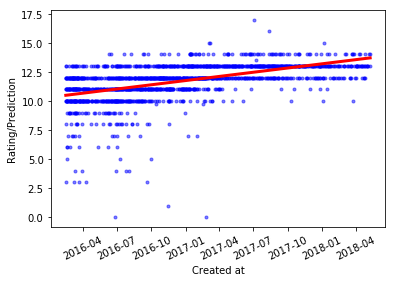

In [8]:

plt.xticks(rotation=25)
plt.plot(data['created_at'], data['rating'], 'b.', alpha=0.5)
plt.plot(data['created_at'], data['prediction'], 'r-', linewidth=3)
plt.xlabel('Created at')
plt.ylabel('Rating/Prediction')
plt.show()